In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from joblib import dump, load
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

**1. LOAD & EXAMINE THE RAW DATA**

**Optional: Load the processed datasets instead of starting from scratch** <br>
Only run the below cell if wanting to train the model immediately **without** data manipulation and EDA.

In [ ]:
X_train = np.load('../data/processed/X_train.npy')
X_val = np.load('../data/processed/X_val.npy')
X_test = np.load('../data/processed/X_test.npy')
y_train = np.load('../data/processed/y_train.npy')
y_val = np.load('../data/processed/y_val.npy')
y_test = np.load('../data/processed/y_test.npy')

**Starting from scratch: EDA and data transformation**

In [3]:
df_raw = pd.read_csv('../data/raw/beer_reviews.csv')
df_raw.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [4]:
print(f'Shape of df_raw: {df_raw.shape}')
print(f'df_raw contains {df_raw.isnull().values.ravel().sum()} of rows with NaN values \n')

df_raw.info()
df_raw.describe()

Shape of df_raw: (1586614, 13)
df_raw contains 68148 of rows with NaN values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
brewery_id            1586614 non-null int64
brewery_name          1586599 non-null object
review_time           1586614 non-null int64
review_overall        1586614 non-null float64
review_aroma          1586614 non-null float64
review_appearance     1586614 non-null float64
review_profilename    1586266 non-null object
beer_style            1586614 non-null object
review_palate         1586614 non-null float64
review_taste          1586614 non-null float64
beer_name             1586614 non-null object
beer_abv              1518829 non-null float64
beer_beerid           1586614 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.518829e+06,1.586614e+06
mean,3.130099e+03,1.224089e+09,3.815581e+00,3.735636e+00,3.841642e+00,3.743701e+00,3.792860e+00,7.042387e+00,2.171279e+04
std,5.578104e+03,7.654427e+07,7.206219e-01,6.976167e-01,6.160928e-01,6.822184e-01,7.319696e-01,2.322526e+00,2.181834e+04
min,1.000000e+00,8.406720e+08,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,3.000000e+00
25%,1.430000e+02,1.173224e+09,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00,1.717000e+03
50%,4.290000e+02,1.239203e+09,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00,1.390600e+04
75%,2.372000e+03,1.288568e+09,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00,3.944100e+04
max,2.800300e+04,1.326285e+09,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01,7.731700e+04


**2. FIND WHAT BEER STYLES HAVE NO ALCOHOL**

From the `df_raw.info()` above, we can see that there are NaN values in column `beer_abv`. <br>
However, if we group the data by column `beer_style`, it shows **no rows** with NaN values. <br>
This suggests the NaN values in column `beer_abv` indicating some beers contain no alcohol at all.

In [5]:
group = df_raw[['beer_style', 'beer_abv']]
group = group.groupby('beer_style').agg('mean')

print(group.head())
print('number of rows with NaN: ', group.isnull().values.ravel().sum())

                             beer_abv
beer_style                           
Altbier                      5.828578
American Adjunct Lager       4.861859
American Amber / Red Ale     6.032033
American Amber / Red Lager   4.959130
American Barleywine         10.703816
number of rows with NaN:  0


**3. CLEAN UP THE RAW DATA**

Because some beers contain no alcohol, we replace NaN values with 0. <br>
The cleaned data shows there are 15 rows with missing values in column `brewery`.

In [6]:
df = df_raw.copy()

keep = ['brewery_name', 'review_overall', 'review_aroma', 'review_appearance',
       'review_palate', 'review_taste', 'beer_abv', 'beer_style']

df = df[keep]

df.rename(columns={'brewery_name':'brewery', 'review_overall':'overall', 
                   'review_aroma':'aroma', 'review_appearance':'appearance', 
                   'review_palate':'palate', 'review_taste':'taste', 
                   'beer_abv':'alcohol', 'beer_style':'type'}, 
          inplace=True)

df['alcohol'] = df['alcohol'].fillna(0)

df.info()
print(f'df contains {df.isnull().values.ravel().sum()} of rows with NaN values')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 8 columns):
brewery       1586599 non-null object
overall       1586614 non-null float64
aroma         1586614 non-null float64
appearance    1586614 non-null float64
palate        1586614 non-null float64
taste         1586614 non-null float64
alcohol       1586614 non-null float64
type          1586614 non-null object
dtypes: float64(6), object(2)
memory usage: 96.8+ MB
df contains 15 of rows with NaN values


**Drop 15 rows of NaN in column brewery**

In [7]:
df.dropna(subset=['brewery'], inplace=True)
df.reset_index(drop=True, inplace=True)

print(f'df contains {df.isnull().values.ravel().sum()} of rows with NaN values')
df.info()

df contains 0 of rows with NaN values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586599 entries, 0 to 1586598
Data columns (total 8 columns):
brewery       1586599 non-null object
overall       1586599 non-null float64
aroma         1586599 non-null float64
appearance    1586599 non-null float64
palate        1586599 non-null float64
taste         1586599 non-null float64
alcohol       1586599 non-null float64
type          1586599 non-null object
dtypes: float64(6), object(2)
memory usage: 96.8+ MB


**4. EXPLORATORY ANALYSIS**

**Check for multicolinearity**

Neural networks generally do not suffer from multicollinearity because they tend to be overparameterized. <br>
The extra learned weights create redundancies that make things that affect any small subset of features (such as multicollinearity) unimportant.

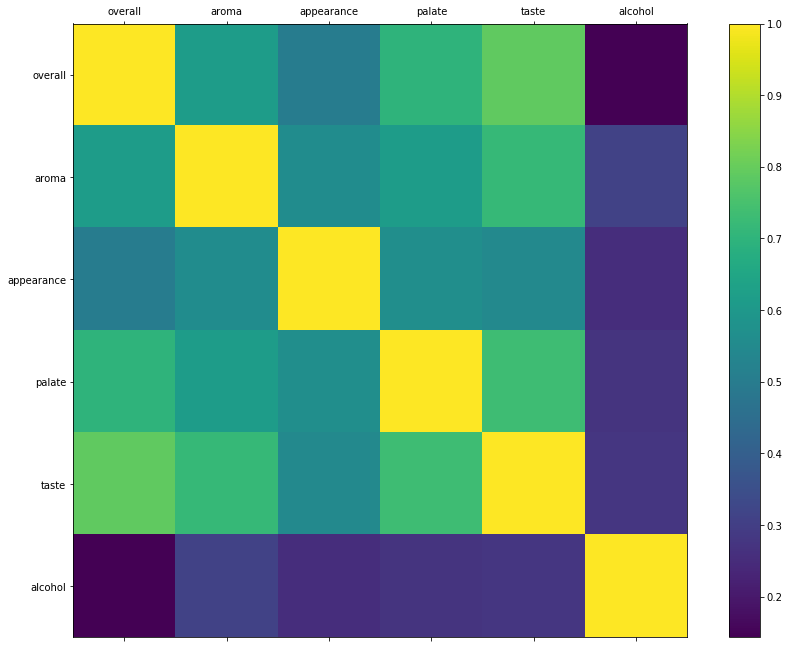

In [8]:
X = df[df.columns[1:-1]]
f = plt.figure(figsize=(15, 11))
plt.matshow(X.corr(), fignum=f.number)
plt.xticks(ticks=range(0,6), labels=X.columns)
plt.yticks(ticks=range(0,6), labels=X.columns)
plt.colorbar()
plt.savefig('../reports/figures/correlation_heatmap.png')
plt.show()

**Check for scale variances in numeric predictors**

We can see that the predictor`alcohol` has a larger value range compared to other numeric predictors.

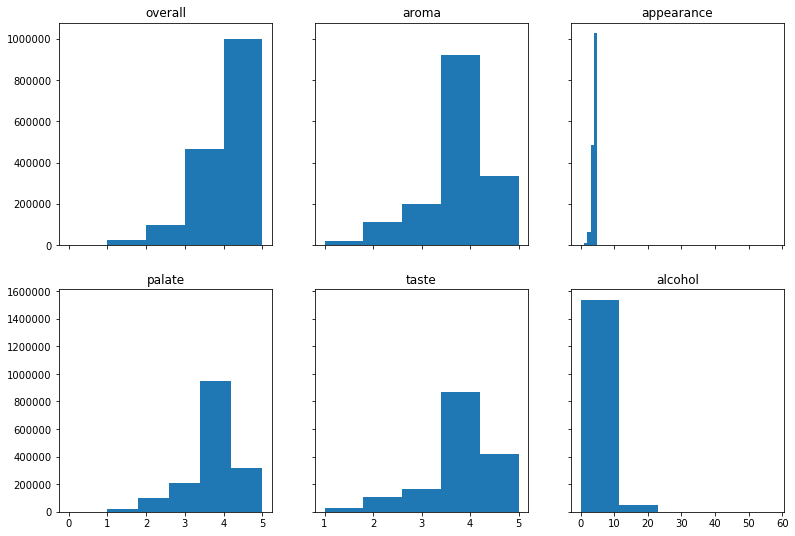

In [9]:
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(13,9))

k = 0
for i in range(2):
    for j in range(3):
        ax[i, j].hist(X.iloc[:, k], bins=5)
        ax[i, j].set_title(df.columns[1:-1][k])
        k +=1

**Check for number of unique values in the column `brewery`**

In [10]:
print(f'Number of breweries: {df["brewery"].unique().shape[0]}')

Number of breweries: 5742


**5. CONVERT TEXT TO NUMBERIC VALUES**

**Neural Network (NN)** requires numeric inputs. We use `OrdinalEncoder` to convert text to numeric values in columns `brewery` and `type`.

In [11]:
# Create a dictionary with relevant column names as keys 
cats_dict = {
    'brewery': [df['brewery'].unique().tolist()],
    'type': [df['type'].unique().tolist()]
} 

# Apply ordinal encoder to the columns of the data
# and save the encoder for use later
for col, cats in cats_dict.items():
    ord_encoder = OrdinalEncoder(categories=cats)
    df[col] = ord_encoder.fit_transform(df[[col]])
    dump(ord_encoder, '../models/ord_encoder_' + col+ '.joblib')

**6. SCALE FEATURES & CONVERT TARGET VARIABLE INTO INTEGER** 

Scaling features will help **NN** gradient descent converging much faster. <br>
Labels are required to be of integer values.

In [12]:
scale = StandardScaler()
num_cols = ['brewery', 'overall', 'aroma', 'appearance', 'palate', 'taste',
       'alcohol']

# Scale relevant features and save the scaler
df[num_cols] = scale.fit_transform(df[num_cols])
dump(scale, '../models/scaler.joblib')

# Convert target into integer
df['type'] = df['type'].astype(int)

**Check for class distribution in the target variable**

We can see that there are more than 100 beer types and they are very imbalanced.

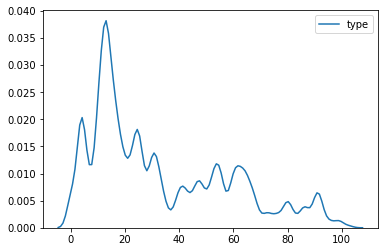

In [13]:
sns.kdeplot(df['type'])
plt.savefig('../reports/figures/density_plot.png')
plt.show()

**7. SPLIT DATA INTO TRAIN, VALIDATION AND TEST SETS**

We use a custom function `split_stratified_sets` to split the data into subsets to ensure each set contains the same ratio of beer tyypes.

In [14]:
from src.data.sets import split_stratified_sets, save_sets
X_train, y_train, X_val, y_val, X_test, y_test = split_stratified_sets(df, 
                                                                       target_col='type', 
                                                                       test_ratio=0.2)
save_sets(X_train=X_train, y_train=y_train, 
          X_val=X_val, y_val=y_val, 
          X_test=X_test, y_test=y_test, 
          path='../data/processed/')

**Check for class ratios in each subset** <br>
We can see that the subsets have the similar class ratios.

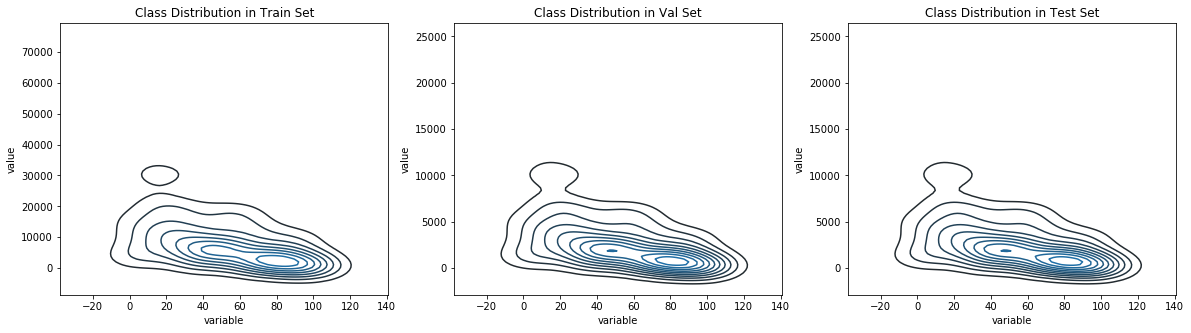

In [15]:
# Define function to get class distribution
def get_class_distribution(obj):
    count_dict = {k:0 for k in df['type'].unique()}   
    for i in obj:
        count_dict[i] += 1                        
    return count_dict

# Visualise the class distribution in each subset
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
# Train
sns.kdeplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt()['variable'], 
            data2 = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt()['value'],
            ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.kdeplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt()['variable'], 
            data2 = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt()['value'],
            ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.kdeplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt()['variable'], 
            data2 = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt()['value'],
            ax=axes[2]).set_title('Class Distribution in Test Set')

plt.savefig('../reports/figures/class_distribution.png')
plt.show()

**8. ESTABLISH METRICS OF A NULL MODEL**

In [18]:
from src.models.null import NullModel
from src.models.performance import print_class_perf

baseline_model = NullModel(target_type='classification')
y_base = baseline_model.fit_predict(y_train)
print_class_perf(y_base, y_train, set_name='Training', average='weighted')

Accuracy Training: 0.07411033458373732
F1 Training: 0.010226773759219075


**9. CONVERT DATASETS INTO TENSORS**

Pytorch models require inputs of tensor datatype

In [17]:
from src.models.pytorch import PytorchDataset

train_dataset = PytorchDataset(X=X_train, y=y_train)
val_dataset = PytorchDataset(X=X_val, y=y_val)
test_dataset = PytorchDataset(X=X_test, y=y_test)

**10. OVERSAMPLING**

Although we stratified split the data to ensure similar class ratios in each data subset, it wouldn't ensure the model seeing all classes in each mini batch. We therefore need to oversample the minority classes by using `WeightedRandomSampler`

In [20]:
# This contains the classes of 951959 rows in the train_dataset
target_list = []
for _, t in train_dataset:
    target_list.append(t)
target_list = torch.tensor(target_list, dtype=torch.long) 

# Class_count contains the count for each class (beer types)
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights) 

tensor([5.9723e-05, 3.4734e-04, 2.7902e-04, 7.5228e-05, 1.9385e-05, 1.6124e-04,
        1.1646e-04, 9.1853e-05, 1.8318e-04, 4.2052e-04, 2.6260e-05, 3.3019e-05,
        4.4160e-05, 1.4174e-05, 6.7926e-05, 3.0791e-05, 3.6429e-05, 5.2173e-05,
        7.0857e-05, 5.4206e-05, 1.3096e-04, 9.2515e-05, 8.5332e-05, 9.5557e-05,
        4.9220e-05, 3.2870e-05, 8.6118e-05, 1.8968e-04, 1.4881e-04, 1.3233e-04,
        6.2360e-05, 5.2927e-05, 7.6811e-05, 1.5706e-04, 1.0718e-04, 3.7552e-04,
        6.1200e-04, 3.5778e-04, 1.3870e-03, 1.7709e-04, 9.6834e-05, 1.4459e-04,
        1.0444e-04, 2.1529e-04, 1.9743e-04, 2.0986e-04, 1.6453e-04, 6.8861e-05,
        1.2658e-04, 1.6961e-04, 1.8619e-04, 1.7899e-04, 1.8252e-04, 5.5297e-05,
        1.4560e-04, 5.2944e-05, 1.2137e-04, 7.2046e-04, 4.1271e-04, 1.3082e-04,
        7.1220e-05, 1.3364e-04, 5.4957e-05, 3.3367e-04, 6.5885e-05, 8.0665e-05,
        5.5804e-04, 8.3410e-05, 2.5013e-04, 2.3397e-04, 3.5714e-03, 6.4392e-04,
        2.5471e-04, 2.4771e-04, 1.0776e-

**Allocate weight to each class in the train dataset**

In [22]:
class_weights_all = class_weights[target_list]
print(type(class_weights_all), class_weights_all.shape)
class_weights_all

<class 'torch.Tensor'> torch.Size([951959])


tensor([7.6811e-05, 1.1337e-04, 1.9385e-05,  ..., 4.4160e-05, 4.9220e-05,
        2.1182e-04])

**Create `weighted_sampler`**

In [23]:
from torch.utils.data import WeightedRandomSampler
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

**11. INITIALISE A NEURAL NETWORK MODEL**

The model's architecture is discussed in depth in the report.

In [24]:
from src.models.pytorch import get_device
from src.models.pytorch import PytorchMultiClass

num_features = X_train.shape[1]
num_classes = df['type'].unique().shape[0]
device = get_device()
model = PytorchMultiClass(num_features, num_classes)
model.to(device)

PytorchMultiClass(
  (layer_1): Linear(in_features=7, out_features=256, bias=True)
  (layer_out): Linear(in_features=256, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
)

**12. SET UP HYPERPARAMETERS** 

* We choose `Adam` optimiser as it is the best among the adaptive optimizers in most of the cases. <br>
* Batch size affects `Adam` optimizer. Common batch sizes 16, 32, and 64 can be used. <br>
Results show that there is a sweet spot for batch size, where a model performs best.

https://stats.stackexchange.com/questions/308424/how-does-batch-size-affect-adam-optimizer

In [25]:
N_EPOCHS = 200
BATCH_SIZE = 32
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

**13. TRAIN AND VALIDATE THE MODEL**

In [34]:
from src.models.pytorch import train_classification, test_classification

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_classification(train_dataset, model=model, 
                                                 criterion=criterion, 
                                                 optimizer=optimizer, 
                                                 batch_size=BATCH_SIZE, 
                                                 device=device,
                                                 weighted_sampler=weighted_sampler)
    valid_loss, valid_acc = test_classification(val_dataset, model=model, 
                                                criterion=criterion, 
                                                batch_size=BATCH_SIZE, device=device)   
    print(f'Epoch: {epoch}')
    print(f'\t(train)\t|\tLoss: {train_loss: f}\t|\tAcc: {train_acc * 100:.1f}%')
    print(f'\t(valid)\t|\tLoss: {valid_loss:.4f}\t|\tAcc: {valid_acc * 100:.1f}%')

Epoch: 0
	(train)	|	Loss:  0.139381	|	Acc: 20.1%
	(valid)	|	Loss: 0.1417	|	Acc: 12.7%
Epoch: 1
	(train)	|	Loss:  0.139384	|	Acc: 20.1%
	(valid)	|	Loss: 0.1417	|	Acc: 12.7%
Epoch: 2
	(train)	|	Loss:  0.139368	|	Acc: 20.1%
	(valid)	|	Loss: 0.1417	|	Acc: 12.7%


KeyboardInterrupt: 